In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda
import pandas as pd
import os
import xarray as xr

from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
cmip_path = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'

In [4]:
def get_model_name(path):
    names = []
    files = glob.glob(path+'/*.nc')
    for f in files:
        fname = os.path.basename(f)
        #ipdb.set_trace()
        model = fname.split('_')[2]
        names.append(model)
    return names

In [5]:
shear_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100')

In [6]:
tcw_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100')

In [7]:
model_names = list(set(shear_names).intersection(set(tcw_names)))

In [8]:
len(model_names)

38

In [9]:
model_names

['MIROC-ESM',
 'HadGEM2-ES',
 'MIROC5',
 'MPI-ESM-LR',
 'GISS-E2-H',
 'BNU-ESM',
 'CMCC-CMS',
 'ACCESS1-0',
 'GFDL-ESM2M',
 'CSIRO-Mk3-6-0',
 'bcc-csm1-1-m',
 'bcc-csm1-1',
 'CMCC-CESM',
 'MRI-ESM1',
 'CanESM2',
 'ACCESS1-3',
 'IPSL-CM5A-MR',
 'MIROC-ESM-CHEM',
 'CESM1-CAM5',
 'NorESM1-M',
 'MRI-CGCM3',
 'NorESM1-ME',
 'GFDL-CM3',
 'GFDL-ESM2G',
 'MPI-ESM-MR',
 'GISS-E2-H-CC',
 'GISS-E2-R-CC',
 'CCSM4',
 'CESM1-BGC',
 'FGOALS-g2',
 'FIO-ESM',
 'GISS-E2-R',
 'inmcm4',
 'HadGEM2-CC',
 'CNRM-CM5',
 'CMCC-CM',
 'IPSL-CM5B-LR',
 'IPSL-CM5A-LR']

In [38]:
dic30 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
dic40 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
dic60 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
dic80 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/'

lpaths = [('shear', shear_path_hist, shear_path_fut, 'unknown'), ('tcw', tcw_path_hist, tcw_path_fut, 'prw')]
periods = [(2020, 2050, dic30, '2030'), (2030, 2060, dic40, '2040'), (2050,2080, dic60, '2060'), (2070,2100, dic80, '2080')]

dics = [(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , (dic80, '2070-2100')]

for mn in model_names:
    
    print('Doing', mn)
    
    for pp in periods:

        (pp[2])['model_name'].append(mn)

        for l in lpaths:
            print('Starting', l, mn)
            hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]
            fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
            hist = xr.open_dataset(hp)
            fut = xr.open_dataset(fp)
            #fut = xr.decode_cf(fut)
            var = l[3]

            if var not in fut.keys():
                var = 'unknown'
            try:
                fut_diff =  (fut[var])[(fut['time.year']>=pp[0]) & (fut['time.year']<pp[1])].mean('time')
            except:
                ipdb.set_trace()
            
            diff = np.abs(fut_diff)-np.abs(hist[var])
#             if 'shear' in l[0]:
#                 diff.values = np.abs(diff.values)
                
            shift = uda.shift_lons_data(diff)
        
            hhist = uda.shift_lons_data(hist[var])
#             if 'shear' in l[0]:
#                 hhist.values = np.abs(hhist.values)

            shift = shift.sel(lon=slice(-20,20), lat=slice(0,30))
            
            shift.values[(shift.values>500) | (shift.values<-500)]=np.nan

            (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(-5,15), lat=slice(9,20)).mean().squeeze().values))
            (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(-5,15), lat=slice(9,20)).mean().squeeze().values))
            ltag = l[2].split('/')[-2]
            outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])

            shift = shift.assign_attrs({'model_id':mn})
            
            if os.path.isfile(outp):
                os.remove(outp)
            
            shift.to_netcdf(outp)
            print('Saving', outp)
for dd in dics:
    pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_CMIP.csv')

Doing MIROC-ESM
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') MIROC-ESM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062100_MIROC-ESM_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') MIROC-ESM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062100_MIROC-ESM_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') MIROC-ESM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_20062100_MIROC-ESM_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgam

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: Serializa

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') MPI-ESM-LR
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') MPI-ESM-LR
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') MPI-ESM-LR


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: Serializa

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2060/ua@925-ua@600_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') MPI-ESM-LR
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2060/prw_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') MPI-ESM-LR
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@925-ua@600_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') MPI-ESM-LR


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: Serializa

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_20062300_MPI-ESM-LR_rcp85_r1i1p1_jas_glo.nc
Doing GISS-E2-H
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') GISS-E2-H
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062300_GISS-E2-H_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') GISS-E2-H
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062300_GISS-E2-H_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') GISS-E2-H
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@9

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062100_ACCESS1-0_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') ACCESS1-0
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2060/ua@925-ua@600_20062100_ACCESS1-0_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') ACCESS1-0
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2060/prw_20062100_ACCESS1-0_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') ACCESS1-0
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@925-ua@600_2006210

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062300_bcc-csm1-1_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') bcc-csm1-1
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062300_bcc-csm1-1_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') bcc-csm1-1
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_20062300_bcc-csm1-1_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') bcc-csm1-1
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062300_bc

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@925-ua@600_20062100_CanESM2_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') CanESM2
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_20062100_CanESM2_rcp85_r1i1p1_jas_glo.nc
Doing ACCESS1-3
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') ACCESS1-3
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062100_ACCESS1-3_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') ACCESS1-3
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_2006210

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062100_CESM1-CAM5_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CESM1-CAM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2060/ua@925-ua@600_20062100_CESM1-CAM5_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') CESM1-CAM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2060/prw_20062100_CESM1-CAM5_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CESM1-CAM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@925-ua@600_2

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062100_GFDL-CM3_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') GFDL-CM3
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062100_GFDL-CM3_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') GFDL-CM3
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_20062100_GFDL-CM3_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') GFDL-CM3
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062100_GFDL-CM3_rcp85

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062100_GISS-E2-H-CC_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') GISS-E2-H-CC
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2060/ua@925-ua@600_20062100_GISS-E2-H-CC_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') GISS-E2-H-CC
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2060/prw_20062100_GISS-E2-H-CC_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') GISS-E2-H-CC
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062101_FGOALS-g2_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') FGOALS-g2
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062101_FGOALS-g2_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') FGOALS-g2
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_20062101_FGOALS-g2_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') FGOALS-g2
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062101_FGOALS-g

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2060/prw_20062100_inmcm4_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') inmcm4
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@925-ua@600_20062100_inmcm4_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') inmcm4
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_20062100_inmcm4_rcp85_r1i1p1_jas_glo.nc
Doing HadGEM2-CC
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') HadGEM2-CC
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_2006

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: Serializa

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CNRM-CM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') CNRM-CM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CNRM-CM5


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: Serializa

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2060/ua@925-ua@600_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') CNRM-CM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2060/prw_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CNRM-CM5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua@925-ua@600_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') CNRM-CM5


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: Serializa

Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_20062300_CNRM-CM5_rcp85_r1i1p1_jas_glo.nc
Doing CMCC-CM
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CMCC-CM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2030/ua@925-ua@600_20062100_CMCC-CM_rcp85_r1i1p1_jas_glo.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/', 'prw') CMCC-CM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2030/prw_20062100_CMCC-CM_rcp85_r1i1p1_jas_glo.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/', '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/', 'unknown') CMCC-CM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua@925-ua@600_2006

In [11]:
pd.DataFrame.from_dict(dic30)

,model_name,shear_mean,tcw_mean,tcw_hist,shear_hist
0,MIROC-ESM,2.069246,9.099586,31.950272,8.922399e+00
1,HadGEM2-ES,1.882348,7.083027,25.754727,6.835162e+00
2,MIROC5,0.071273,6.698161,41.363624,1.438931e+01
3,MPI-ESM-LR,1.075303,5.735914,37.175831,1.165972e+01
4,GISS-E2-H,1.171042,4.859830,38.203424,1.320699e+01
5,BNU-ESM,0.539432,7.432512,33.615907,1.078732e+01
6,CMCC-CMS,0.284135,6.249432,36.480856,1.072917e+01
7,ACCESS1-0,1.833631,6.223326,22.597402,4.352988e+00
8,GFDL-ESM2M,0.028545,4.588960,39.729829,9.425083e+00
9,CSIRO-Mk3-6-0,0.376758,4.447740,42.617658,6.041945e+35


In [12]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='jet', extend='both', levels=levels)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(r'mm h$^{-1}$')

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


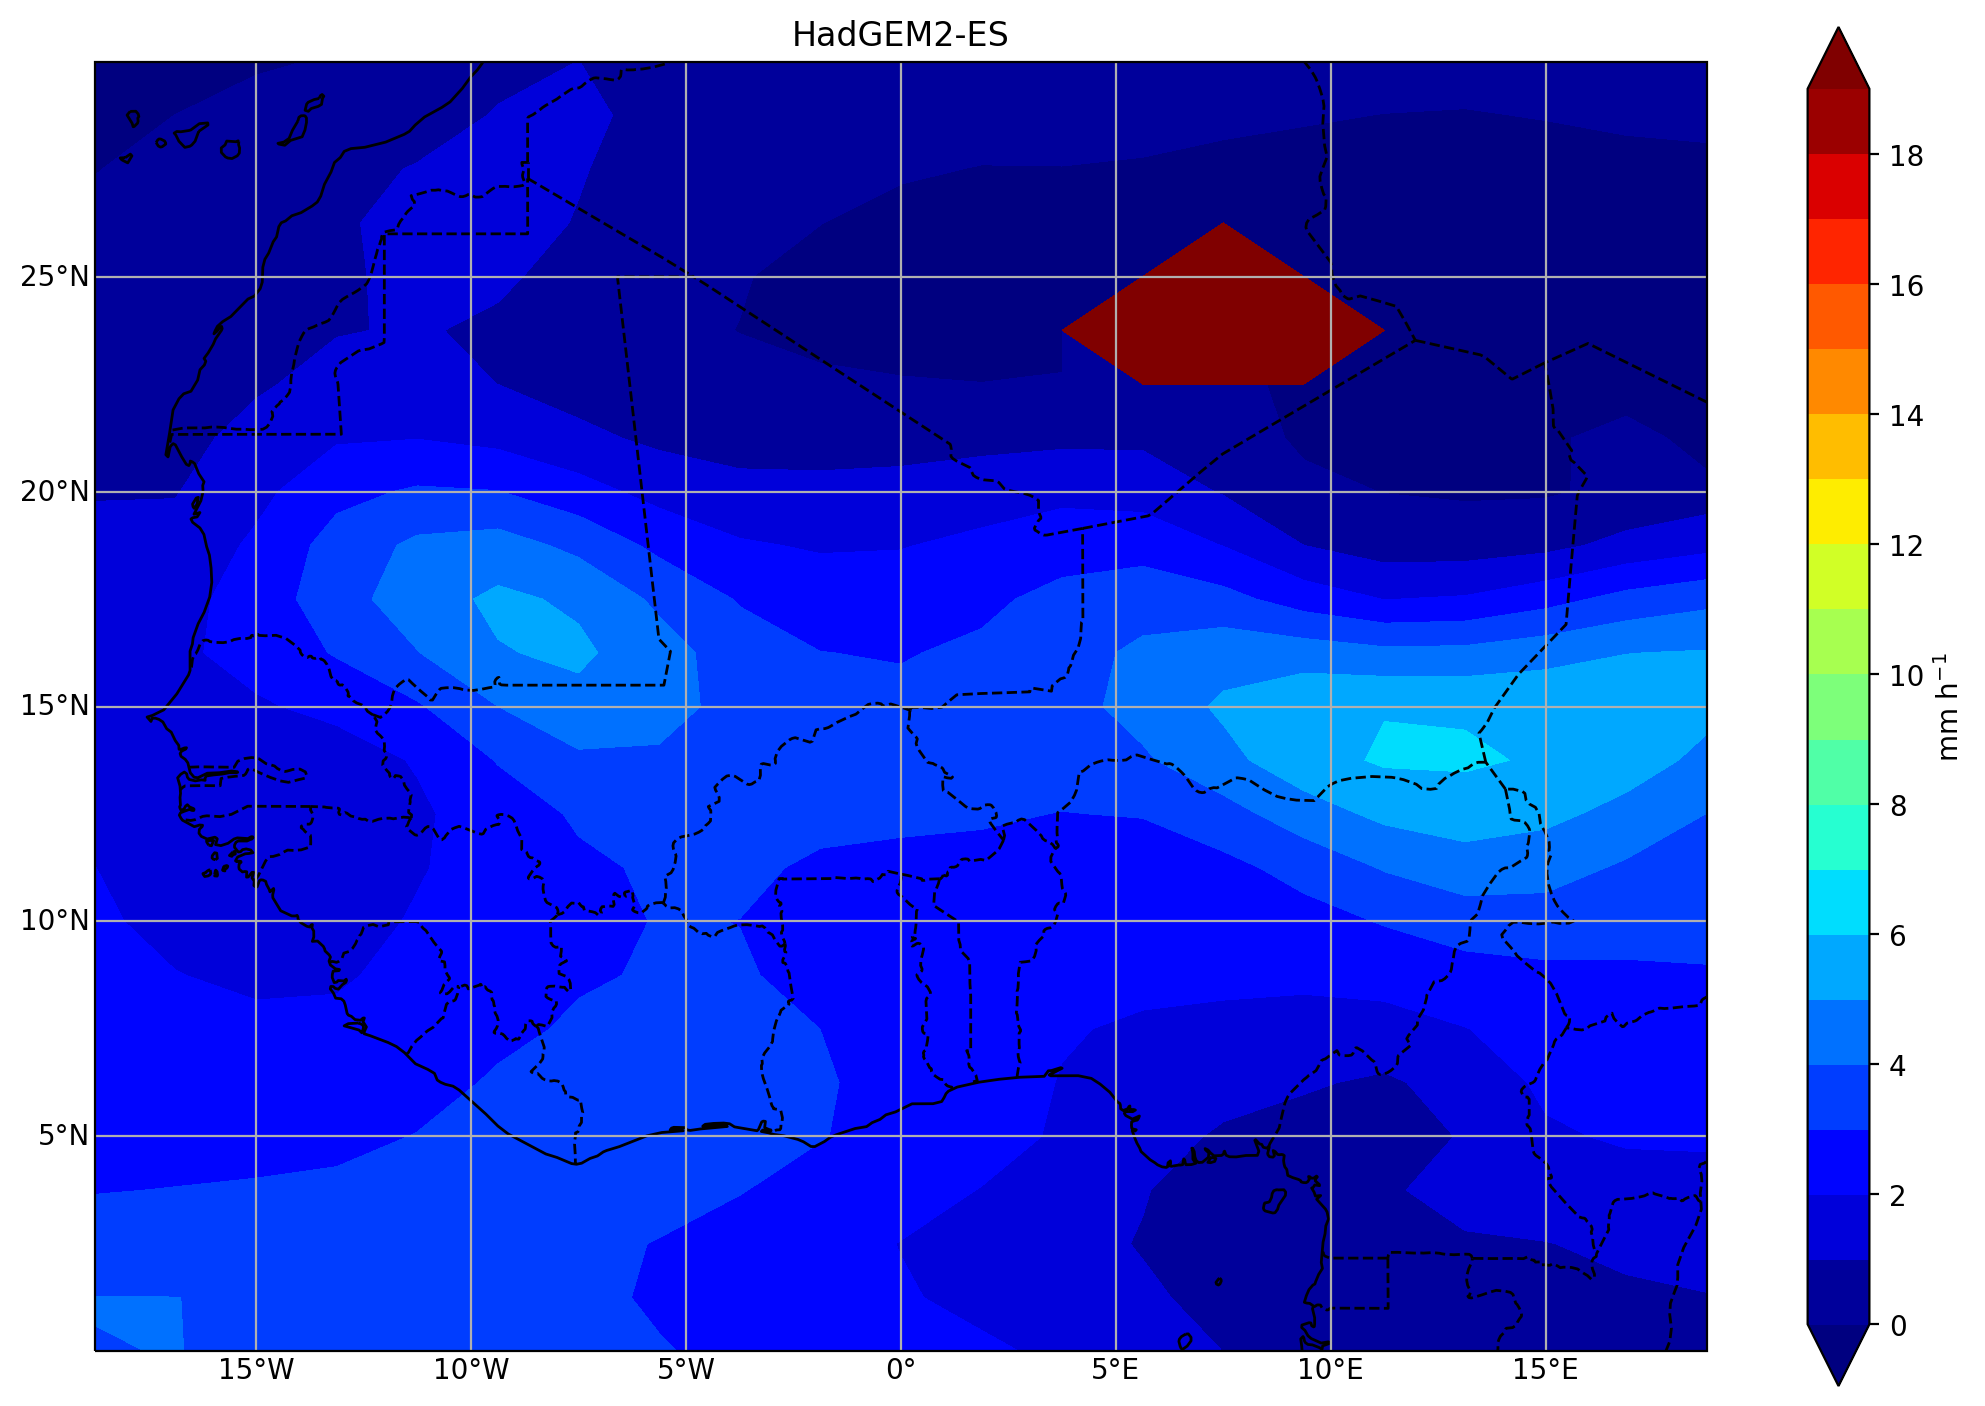

In [13]:
## tcw-test
davemap = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/shear_hist/ua@925-ua@600_Clim20702099-Clim19501999_HadGEM2-ES_rcp85-historical_r1i1p1_jas_glo.nc')
dave = uda.shift_lons_data(davemap['unknown'])
dave = dave.sel(lon=slice(-20,20), lat=slice(0,30))
f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
draw_map(ax, dave, dave.lat, dave.lon, title=davemap.attrs['model_id'], levels=np.arange(0,20))

In [14]:
hist = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_1950-1990/prw_Clim19501999_HadGEM2-ES_historical_r1i1p1_jas_glo.nc')
fut = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_2006-2100/prw_20062299_HadGEM2-ES_rcp85_r1i1p1_jas_glo.nc')

In [15]:
fut_diff =  (fut['prw'])[(fut['time.year']>=2070) & (fut['time.year']<2100)].mean('time')

In [16]:
diff = fut_diff-hist['prw']

In [17]:
shift = uda.shift_lons_data(diff)

In [18]:
shift = shift.sel(lon=slice(-20,20), lat=slice(0,30))

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


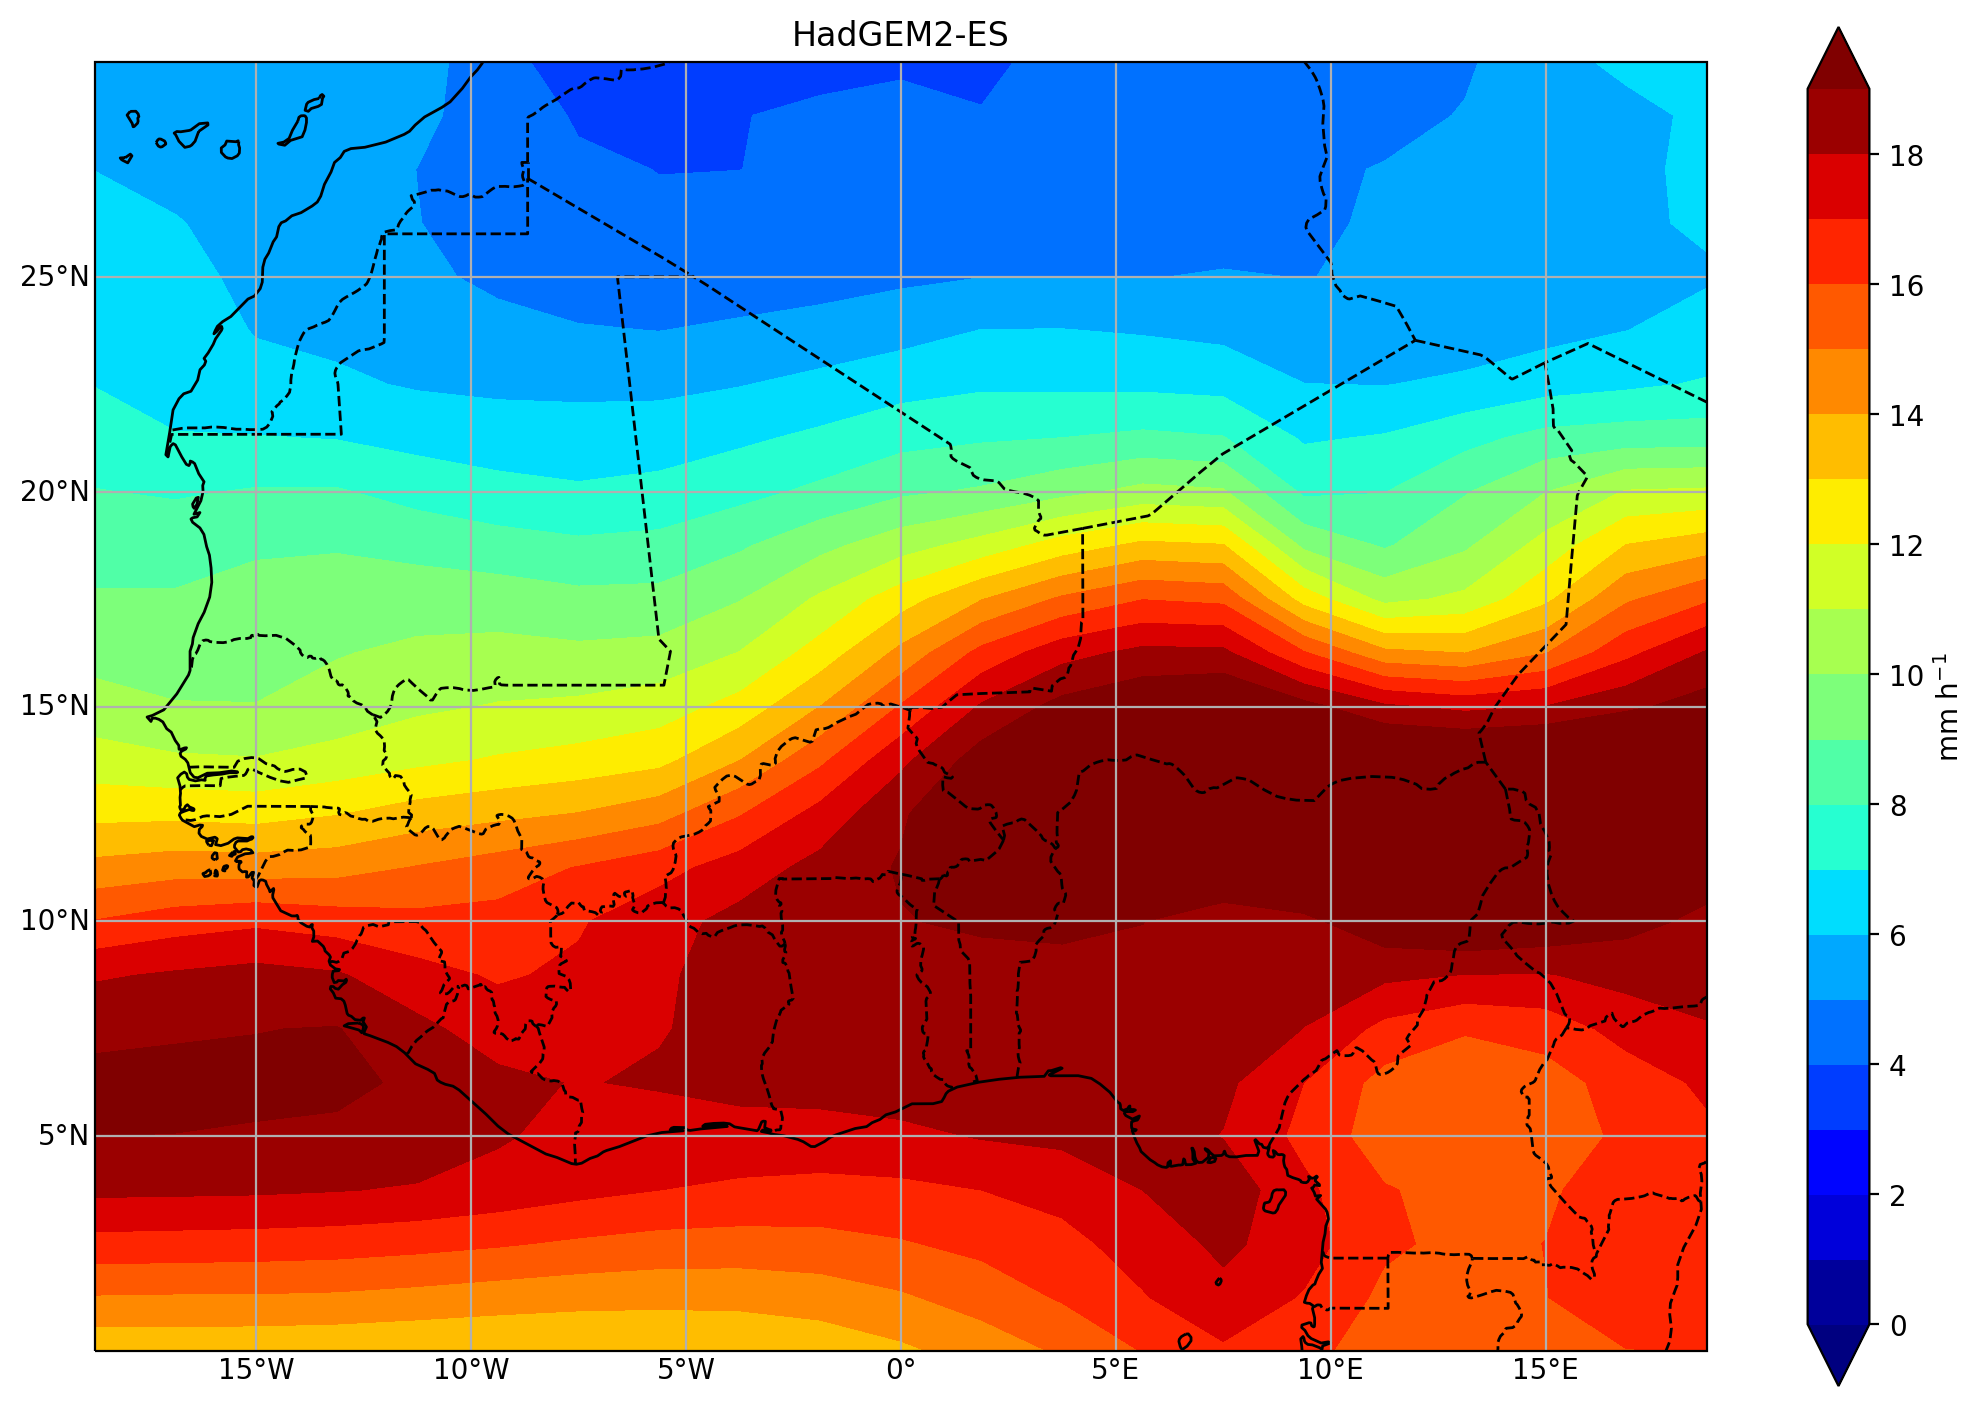

In [19]:
f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
draw_map(ax, shift, shift.lat, shift.lon, title=davemap.attrs['model_id'], levels=np.arange(0,20))

In [32]:
out = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_1950-1990/*_FGOALS-g2_*_jas_glo.nc')[0])

In [34]:
out2 = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_2006-2100/*_FGOALS-g2_*_jas_glo.nc')[0])
out2 = out2.isel(time=slice(85,95)).mean('time')

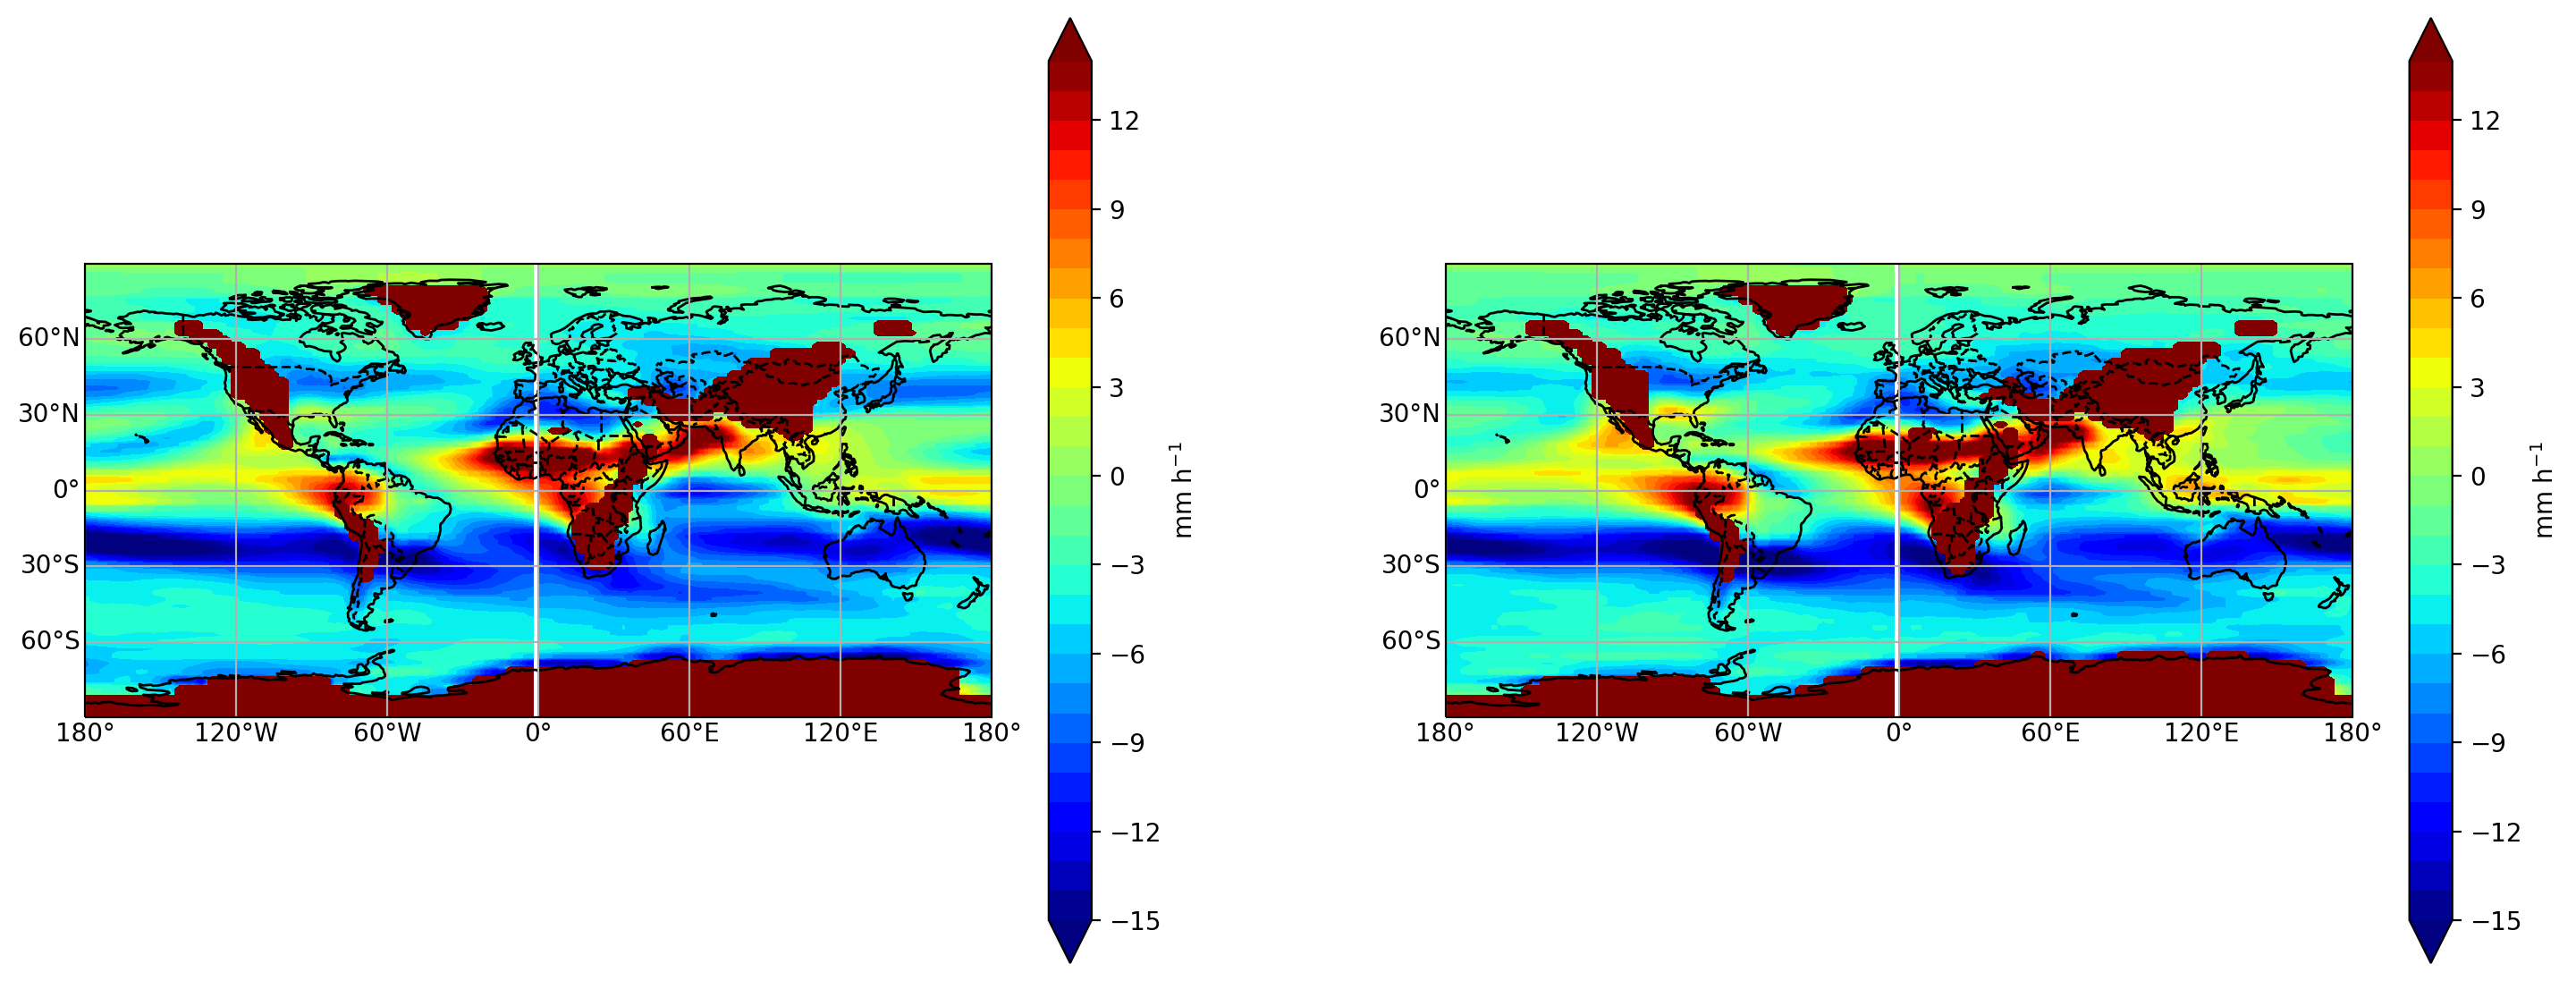

In [36]:
f = plt.figure(figsize=(18,7), dpi=200)
ax = f.add_subplot(121, projection=ccrs.PlateCarree())
draw_map(ax, out['unknown'], out.lat, out.lon, levels=np.arange(-15,15))

ax = f.add_subplot(122, projection=ccrs.PlateCarree())
draw_map(ax, out2['unknown'], out2.lat, out2.lon, levels=np.arange(-15,15))

In [22]:
out2 = xr.open_dataset(glob.glob('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/shear_hist/ua@925-ua@600_Clim20702099-Clim19501999_FGOALS-g2_rcp85-historical_r1i1p1_jas_glo.nc')[0])
out2 = uda.shift_lons_data(out2['unknown'])
out2 = out2.sel(lon=slice(-20,20), lat=slice(0,30))

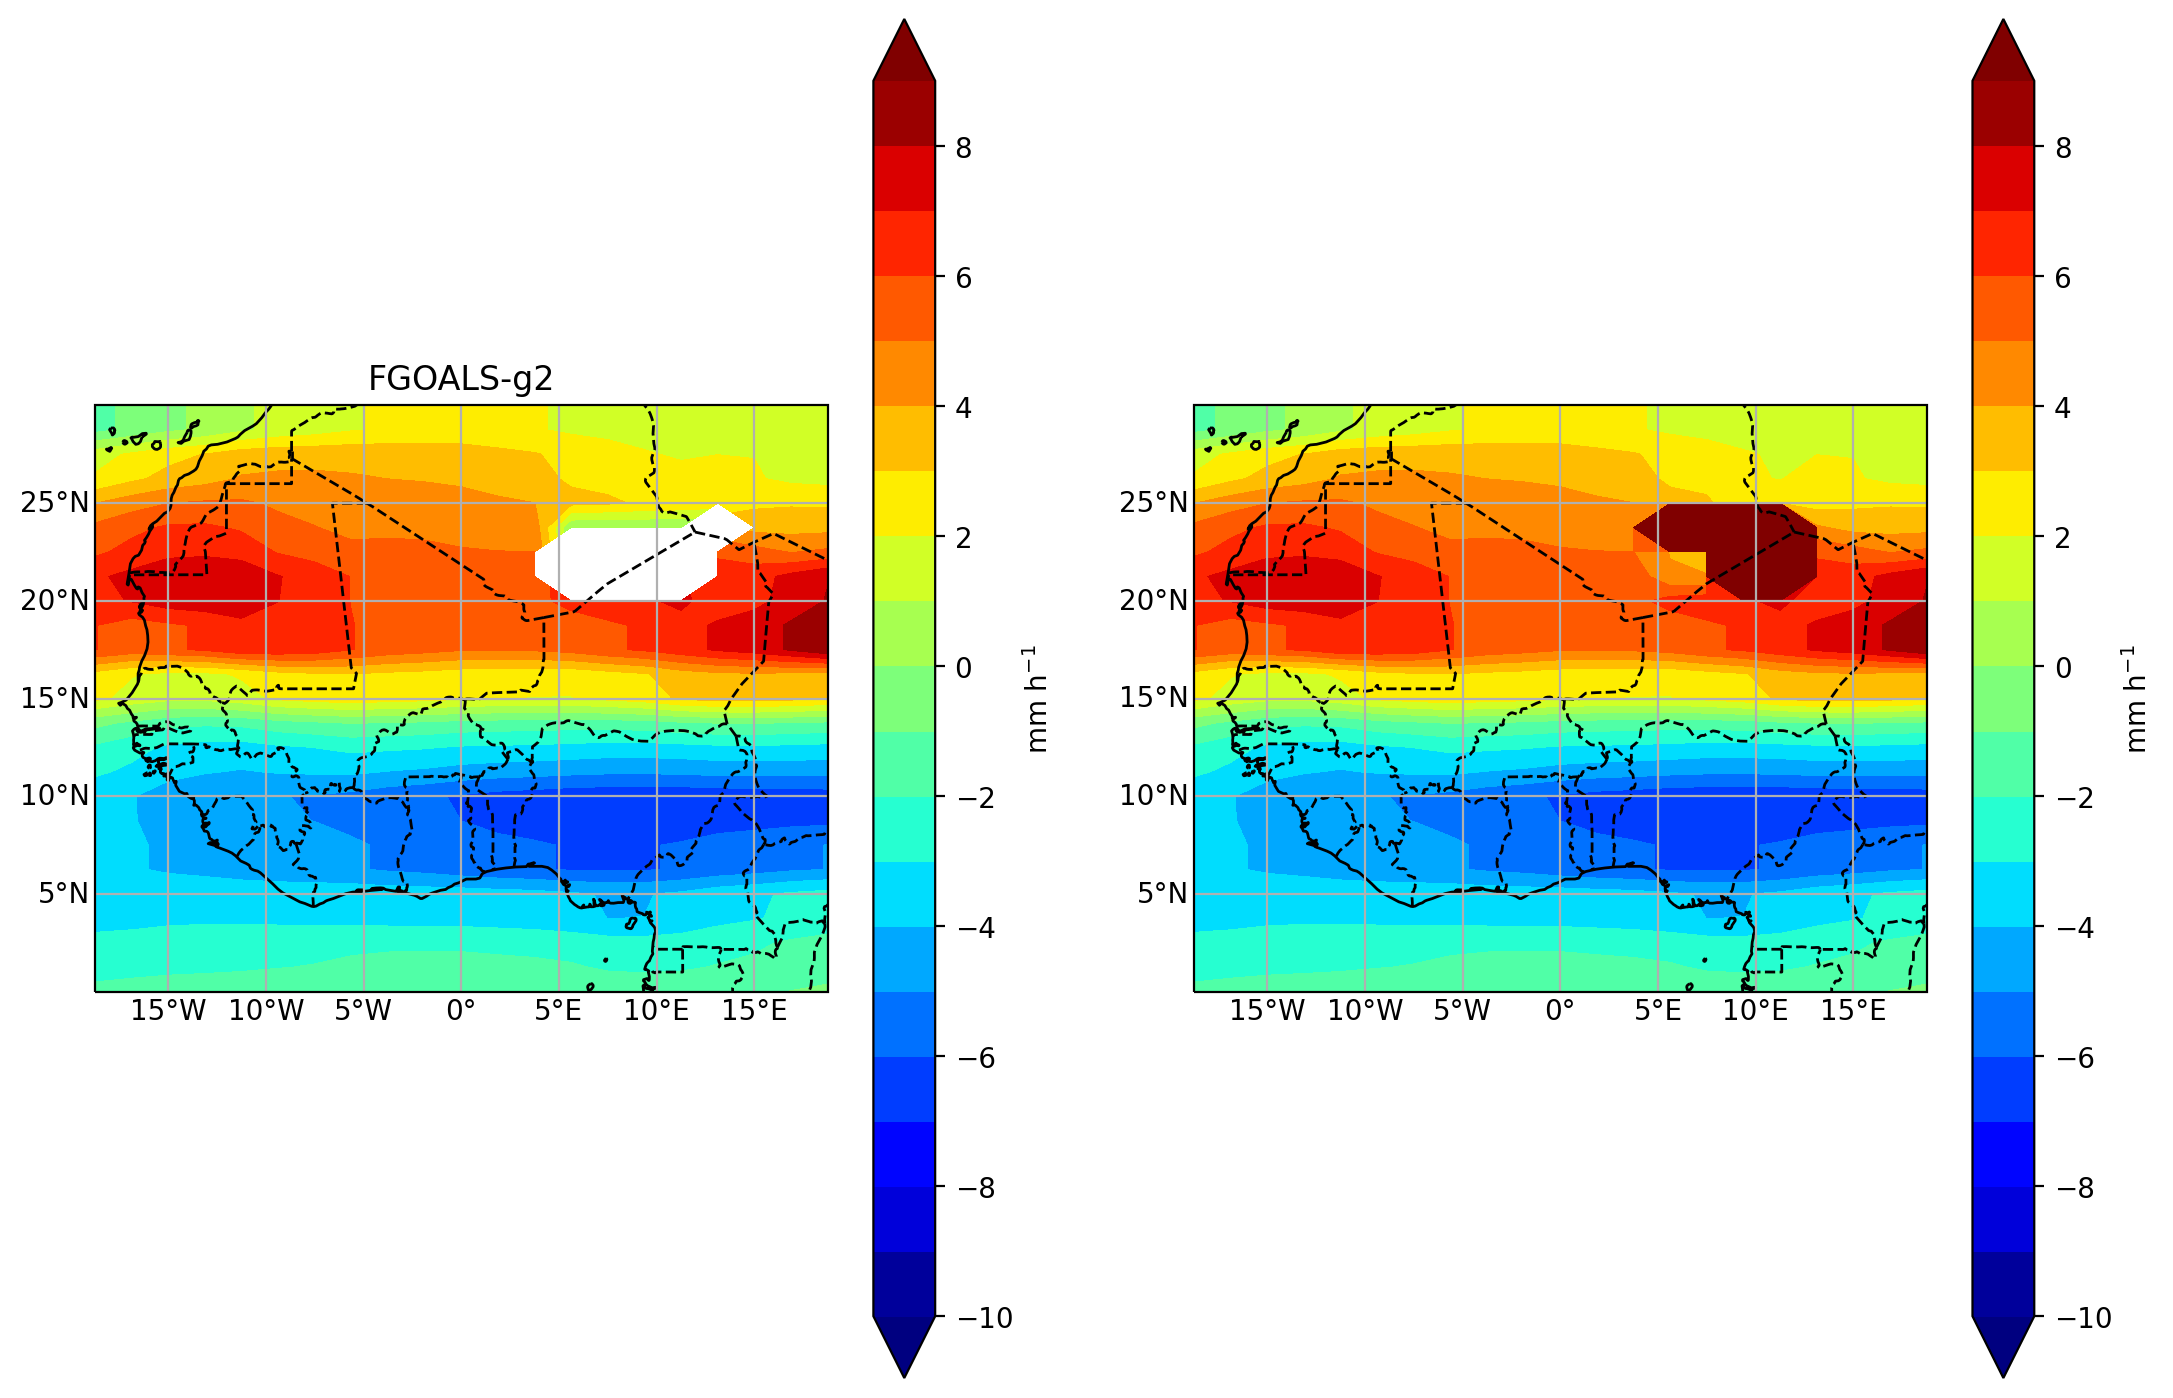

In [24]:
f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(121, projection=ccrs.PlateCarree())
draw_map(ax, out['unknown'], out.lat, out.lon, title=out['unknown'].attrs['model_id'], levels=np.arange(-10,10))
ax2 = f.add_subplot(122, projection=ccrs.PlateCarree())
draw_map(ax2, out2, out2.lat, out2.lon, levels=np.arange(-10,10))